# Predicting survivors on Titanic

## Dependencies

In [170]:
# Import Dependencies
%matplotlib inline

from importlib import reload

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Data Imputation
import datawig

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns

# Models
from sklearn.model_selection import train_test_split

plt.style.use('seaborn-whitegrid')

## Information from the problem description

* There were 2224 people aboard, out of which 1502 died.
* The massive loss of life is mostly due to lack of lifeboats on the ship.
* Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

## Loading the data

In [3]:
# Import train & test data 
train = pd.read_csv('data/train.csv', index_col='PassengerId')
test = pd.read_csv('data/test.csv')
gender_submission = pd.read_csv('data/gender_submission.csv') # example of what a submission should look like

In [4]:
train.head(15)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


**Survival:** 0 = No, 1 = Yes

**pclass (Ticket class):** 1 = 1st, 2 = 2nd, 3 = 3rd

**sex:** Sex

**Age:** Age in years

**sibsp:** number of siblings/spouses aboard the Titanic

**parch:** number of parents/children aboard the Titanic

**ticket:** Ticket number

**fare:** Passenger fare

**cabin:** Cabin number

**embarked:** Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [241]:
# We will progressively copy the training dataframe into separate dataframes
# since it is proferrable to not modify the original dataset in this case
df_train = train.copy()
df_train['Sex'] = df_train['Sex'].astype('category') # Since sex is initially string, make it into a category
df_train['Embarked'] = df_train['Embarked'].astype('category') 
df_train['Survived'] = df_train['Survived'].astype('category') 
df_nom = pd.DataFrame() # for discretised continuous variables - nominal features
df_ord = pd.DataFrame() # for continuous variables - ordinal features

## Missing values

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64


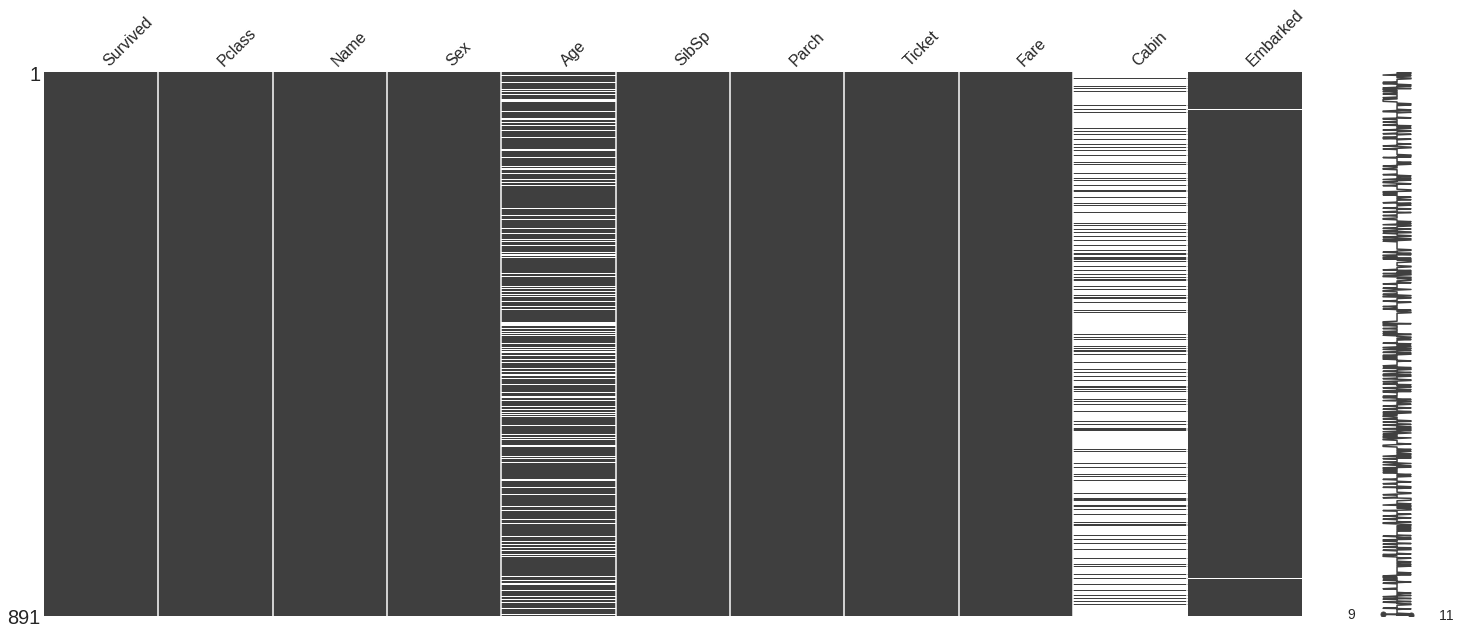

In [7]:
print(train.isnull().sum())
missingno.matrix(train)

Observations:
* Age has almost 20% missing values
* Cabin has 77% missing values
* There are 2 missing values in Embarked. It may be possible to infer them from class and ticket price.

Decisions:
* We may need to have to fill cabin from other sources, or drop it. We will check if its correlated with survival.
* Age will likely have to be filled in, since it is correlated with survival according to the description.
* We may also drop PassengerId, since it is definitely no related to survival.
* Try to impute missing Embarked.

## Duplicates

In [8]:
for _, g in train.groupby("Name"):
    if len(g) > 1:
        print(g)

Observation:
* There seem to be no duplicated names.
* There are duplicated cabins, but that seems to be because cabins are assigned group-wise and multiple people may share the same deck.

## Data imputation

### Imputing missing embarkation

In [16]:
df_train[df_train.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Rare,Deck,FamSize
PassengerId,,,,,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss.,0,B,1
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs.,0,B,1


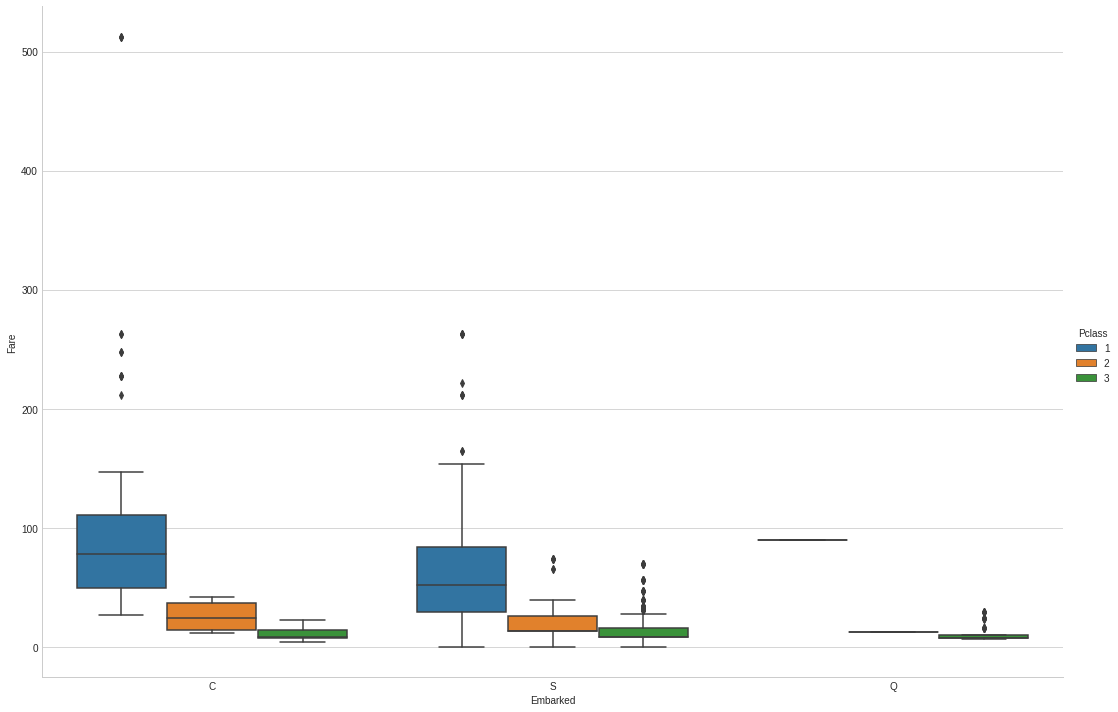

In [17]:
# Plot relationship between Fare, class, and embarked
sns.catplot(
    x='Embarked', y='Fare', hue='Pclass', kind='box', data=train, order=['C', 'S', 'Q'], height= 10, aspect=1.5)

In [18]:
df_train.loc[62, 'Embarked'] = 'S'
df_train.loc[830, 'Embarked'] = 'S'

Observation:
* Median fare for port S corresponds to 80 USD paid by the passengers.

Assumption:
* They embarked from port S.

Decision:
* Impute missing port of embarkation.

### Imputing missing age

#### Datawig

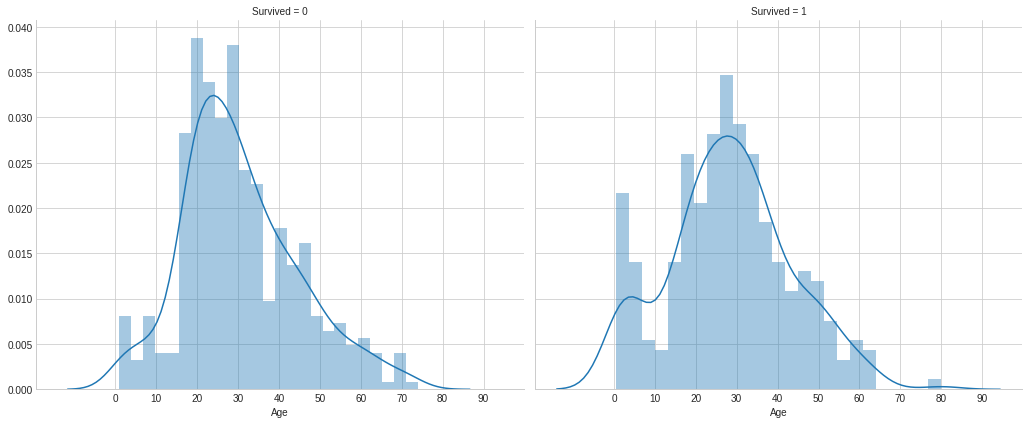

In [34]:
g = sns.FacetGrid(df_train, col='Survived', height=6, aspect=1.2)
g.set(xticks=np.arange(0,len(df_train),10))
g.map(sns.distplot, 'Age', bins=25)

Observation:
* It seems children aged < 5 were much more likely to survive.

Decision:
* Categorize age, put children aged < 5 into a separate category.

In [203]:
import logging

def fit_wo_logging(train_df, num_epochs, imputer):
    logging.disable(logging.WARNING)
    imputer.fit(train_df=train_df, num_epochs=num_epochs)
    logging.disable(logging.NOTSET)
    return imputer
    
def cut(df, start=0, end=81, bins_step=5):
    return pd.cut(df, bins=np.arange(start, end, bins_step))

def evaluate(pred, act, bins_step=5):
    # Get test set accuracy
    imp = pd.concat([pred, act], axis=1).dropna()
    pred = cut(imp.iloc[:, 0])
    act = cut(imp.iloc[:, 1])
    return (pred == act).sum() / len(pred)

def train_dtwg(
    df_train=df_train,
    input_columns=[c for c in df_train.columns if c not in ('Name', 'Cabin', 'Ticket')],
    test_size=0.2,
    num_epochs=100
    ):
    
    df_dtwg = pd.get_dummies(df_train[input_columns])

    df_dtwg_train, df_dtwg_test = datawig.utils.random_split(df_dtwg, split_ratios=[1-test_size, test_size])

    # Initialize a SimpleImputer model
    imputer = datawig.SimpleImputer(
        input_columns=df_dtwg.columns, # column(s) containing information about the column we want to impute
        output_column= 'Age', # the column we'd like to impute values for
        # output_path = 'imputer_model' # stores model data and metrics
    )

    # Fit an imputer model on the train data
    imputer = fit_wo_logging(df_dtwg_train, num_epochs, imputer)
    
    acc = None
    if test_size > 0.0:
        # Impute missing values and return original dataframe with predictions
        pred = imputer.predict(df_dtwg_test)
        acc = evaluate(pred['Age_imputed'], pred['Age'])
        print('Accuracy', acc)
        
    return imputer, acc


accuracies = []
k = 5
for i in range(k):
    _, acc = train_dtwg()
    accuracies.append(acc)
print('Averaged accuracy over {} iterations:'.format(k), np.mean(accuracies))

Accuracy 0.8843537414965986
Accuracy 0.6394557823129252
Accuracy 0.8231292517006803
Accuracy 0.8979591836734694
Accuracy 0.7346938775510204
Averaged accuracy over 5 iterations: 0.7959183673469388


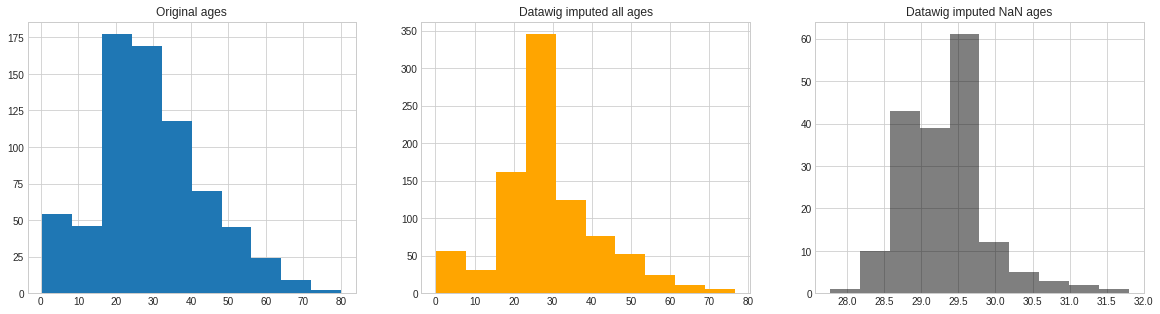

In [207]:
imputer, _ = train_dtwg(df_train, test_size=0.0)

# Plot histogram of imputed ages
dtwg_imp = imputer.predict(pd.get_dummies(df_train))[['Age_imputed']]

# Compare original and imputed distributions of age
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].hist(df_train['Age'].dropna())
ax[0].set_title('Original ages')
ax[1].hist(dtwg_imp.values, facecolor='orange')
ax[1].set_title('Datawig imputed all ages')
ax[2].hist(age_imp[df_train.Age.isnull()].values, facecolor='black', alpha=0.5)
ax[2].set_title('Datawig imputed NaN ages')
plt.show()

Observations:
* Using bins of size 10, we are achieving over 90% accuracy on the test set.
* However, it is quite worrysome that most of the imputed values lie in range 28.5 to 33.

Decisions:
* Do not use age values using  for the age.
* We have to find another way to impute data.

Note:
* It may be preferrable to categorize the data before training, but Datawig does not seem to work well with categorical data.

#### MICE

In [210]:
from impyute.imputation.cs import mice

def train_mice(df_train=df_train, test_size=0.2, col='Age'):
    # Start the MICE training
    dummified = pd.get_dummies(df_train).applymap(float)
    df_mice_train, df_mice_test = \
        train_test_split(dummified, test_size=test_size) if test_size else dummified, None
    imp_train = mice(df_mice_train)
    imp_train.index = df_mice_train.index
    imp_train.columns = df_mice_train.columns 
    if test_size > 0.0:
        # The library currently does not support saving model and predicting
        pass
    return imp_train[col]

/home/miroslav/.local/lib/python3.5/site-packages/impyute/util/preprocess.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  args[0] = args[0].as_matrix()
/home/miroslav/.local/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


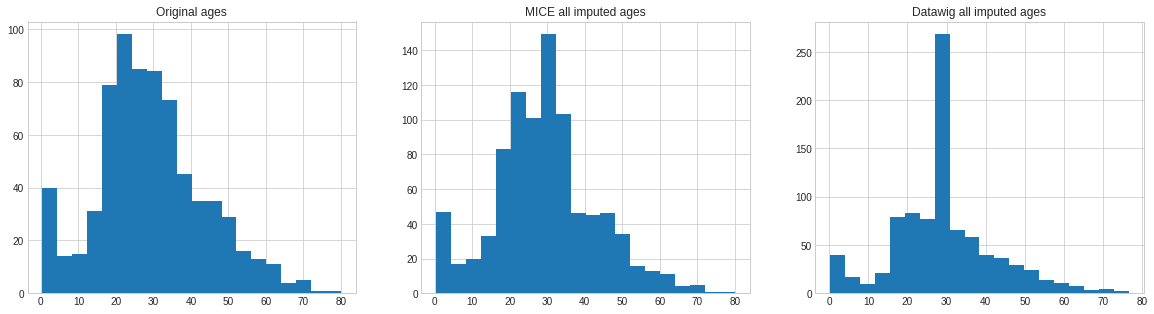

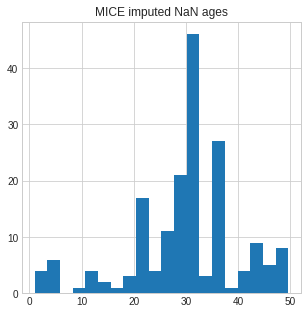

In [223]:
mice_imp = train_mice(df_train, test_size=0.0)
mice_imp[mice_imp <= 0] = 1
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
bins = 20
ax[0].hist(df_train['Age'].dropna(), bins=bins)
ax[0].set_title('Original ages')
ax[1].hist(mice_imp, bins=bins)
ax[1].set_title('MICE all imputed ages')
ax[2].hist(dtwg_imp.values, bins=bins)
ax[2].set_title('Datawig all imputed ages')
fig.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
missing = df_train['Age'].isnull()
ax.hist(mice_imp[missing].values, bins=bins)
ax.set_title('MICE imputed NaN ages')
fig.show()

In [ ]:
# Impute missing values to age column
df_train['Age'][missing] = mice_imp[missing]

Observation:
* Mice seems to preserve the original distribution of ages and has much wider range Datawig. It's result seem more plausible than datawigs.

Decision:
* We will prefer MICE's results over Datawig in models with imputed values.

## Feature engineering

### Titles

All passangers have titles: True
Selected rare titles: ['Capt.', 'Col.', 'Countess.', 'Don.', 'Dr.', 'Jonkheer.', 'Lady.', 'Major.', 'Rev.', 'Sir.']


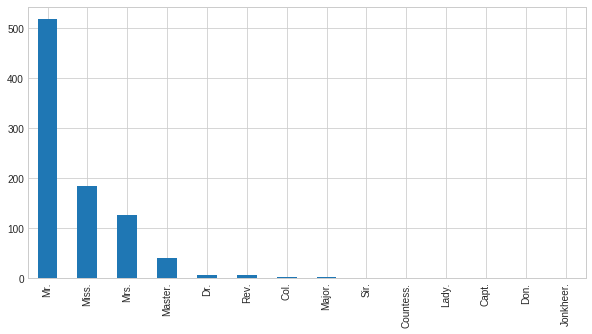

In [9]:
# Get titles from names
def get_title(name):
     return list(filter(lambda x: '.' in x, name.split(' ')))[0]

titles = np.array([get_title(name) for name in train.Name])

# Replace superfluous values
titles[titles == 'Mlle.'] = 'Miss.'
titles[titles == 'Ms.'] = 'Miss.'
titles[titles == 'Mme.'] = 'Mrs.'

# Do all people have titles?
print('All passangers have titles:', len(titles) == len(train))

# Plot histogram of titles
pd.Series(titles).value_counts().plot('bar', figsize=(10,5))

# Add titles and rarity as nominal features
rare = [title for title, count in zip(*np.unique(titles, return_counts=True)) if count < 40]

print('Selected rare titles:', rare)
df_train['Title'] = df_train.apply(lambda r: get_title(r.Name), axis=1).astype('category')
df_train['Rare'] = df_train.apply(lambda r: int(r.Title in rare), axis=1).astype('category')

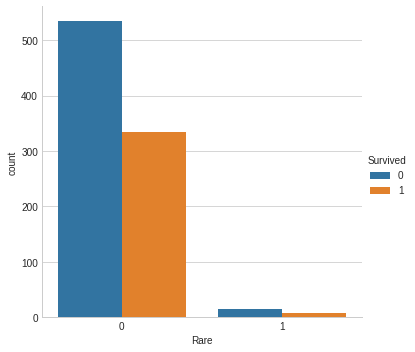

In [10]:
sns.catplot(data=df_train, x='Rare', hue='Survived', kind='count')

Observations:
* All of the names include titles.
* Some of the titles in names are rare.
* Some of the titles are superfluous.
* Bearers of rare titles do not seem to be more likely to survive.

Decisions:
* Do not add title as a feature.

### Cabin

In [11]:
train.Cabin.value_counts()[train.Cabin.value_counts() == 1].index.values

array(['B19', 'D46', 'C86', 'C87', 'D9', 'A14', 'C45', 'B86', 'A36',
       'C99', 'D47', 'C54', 'C30', 'B42', 'E40', 'D37', 'C95', 'D49',
       'D11', 'C110', 'C104', 'C70', 'C91', 'A23', 'C148', 'D45', 'C128',
       'C47', 'E36', 'E10', 'C50', 'E46', 'B80', 'A26', 'C103', 'A6',
       'E34', 'B78', 'A5', 'B71', 'D30', 'F E69', 'D6', 'D19', 'C101',
       'B79', 'E58', 'D28', 'E68', 'E50', 'B4', 'B3', 'D10 D12', 'A20',
       'D56', 'A16', 'B50', 'E12', 'B82 B84', 'A7', 'C118', 'B30', 'A31',
       'E49', 'A19', 'D7', 'E77', 'E17', 'B41', 'B101', 'F G63', 'C32',
       'D50', 'B102', 'D15', 'C90', 'D21', 'E63', 'C7', 'A34', 'B73',
       'C111', 'B69', 'A24', 'C82', 'A10', 'E38', 'D48', 'F38', 'C62 C64',
       'C106', 'C85', 'B39', 'B37', 'C46', 'A32', 'T', 'B94', 'E31',
       'B38', 'C49'], dtype=object)

In [12]:
train[train.Cabin == 'G6']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
206,0,3,"Strom, Miss. Telma Matilda",female,2.0,0,1,347054,10.4625,G6,S
252,0,3,"Strom, Mrs. Wilhelm (Elna Matilda Persson)",female,29.0,1,1,347054,10.4625,G6,S
395,1,3,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",female,24.0,0,2,PP 9549,16.7000,G6,S


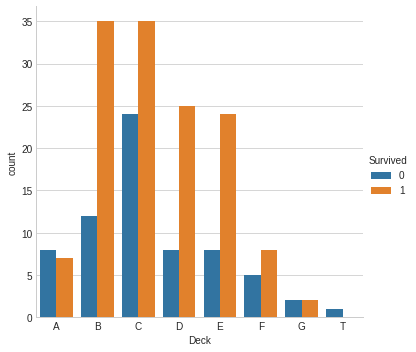

In [13]:
def get_deck(row):
    if row.Cabin is np.NaN:
        return np.NaN
    return str(row.Cabin)[0]

df_train['Deck'] = df_train.apply(lambda r: get_deck(r), axis=1).astype('category')
sns.catplot(data=df_train, x='Deck', hue='Survived', kind='count')

Observations:
* When a group (e.g. family) registered multiple cabins, each passenger seems to have all of the cabins assigned.
* However, some groups have less cabins assigned than the number of persons in group - maybe we can find persons who they are related to and assign them to the same cabin (e.g. based on name). On the other hand, this may be unreliable and just add noise.
* It seems that the lower class sometimes registered multiple persons to a single cabin. Maybe we can quantify that?
* Passengers in cabin A seem slightly more likely to surive (T may be just fluctuation). Maybe we can add a binary feature indicating membership in the class.

Decisions:
* Do not add deck as a feature.

### Family size

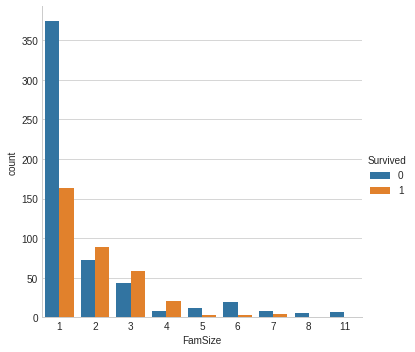

In [14]:
df_train['FamSize'] = train.apply(lambda r: r.SibSp + r.Parch + 1, axis=1)
sns.catplot(data=df_train, x='FamSize', hue='Survived', kind='count')

In [15]:
def get_fam_size(row):
    if row.FamSize == 1:
        return 0
    if 1 < row.FamSize <= 4:
        return 1
    else:
        return 2
    
df_nom['FamSize'] = df_train.apply(lambda r: get_fam_size(r), axis=1).astype('category')
df_train['FamSize'] = df_train.apply(lambda r: get_fam_size(r), axis=1).astype('category')

Observation:
* People travelling in families were more likely to survive for family size 2, 3, 4.

Decision:
* Add family size as a categorical (3 categories) feature for the classifier.

### Mother, father, child, loners

We want to distinguish parents and children. In particular, difference between mothers and fathers may have been important. 

In [239]:
def is_mother(row):
    return row.Age >= 18 and row.Parch > 0 and row.Sex == 'female' and row.Title != 'Miss.'
def is_father(row):
    return row.Age >= 18 and row.Parch > 0 and row.Sex == 'male'
def is_child(row):
    return row.Age < 18 and row.Parch > 0
def is_alone(row):
    return row.FamSize == 1 
def priority(row):
    # TODO: Factor in Sex, maybe fare
    return row.Class * row.Age

df_train['Mother'] = df_train.apply(lambda r: is_mother(r), axis=1)
df_train['Father'] = df_train.apply(lambda r: is_father(r), axis=1)
df_train['Child'] = df_train.apply(lambda r: is_child(r), axis=1)
df_train['Alone'] = df_train.apply(lambda r: is_alone(r), axis=1)
df_train['Priority'] = df_train.apply(lambda r: priority(r), axis=1)

## Prediction